# Jupyter notebook demonstrating some functions from the Tigramite package

In [1]:
# Go to tigramite directory

In [1]:
# Imports
import numpy
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from tigramite import data_processing as pp
from tigramite import plotting
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPACE, CMIknn, CMIsymb


In [2]:
# Example process to play around with
numpy.random.seed(42)
a1 = 0.7; a2 = 0.8; a3 = 0.5; a4 = 0.4;
c1 = .8
c2 = .5
c3 = -.6
T = 253
# Each key refers to a variable and the incoming links are supplied as a
# list of format [((driver, lag), coeff), ...]
links_coeffs = {0: [((0, -1), a1), ((1, -1), c1)],
                1: [((1, -1), a2), ((3, -1), c1)],
                2: [((2, -1), a3), ((1, -2), c2), ((3, -3), c3)],
                3: [((3, -1), a4)],
                }

data, true_parents_neighbors = pp.var_process(links_coeffs,
                                                  use='inv_inno_cov', T=T)
# data = data[:,[0,2]]
T, N = data.shape

# Data mask
data_mask = numpy.zeros(data.shape)

# Initialize dataframe object (also accepts python pandas!)
dataframe = pp.DataFrame(data, mask=data_mask)

# Specify time axis and variable names
datatime = numpy.arange(len(data))
var_names = [r'X1', r'X2', r'X3', r'X4']

verbosity = 2

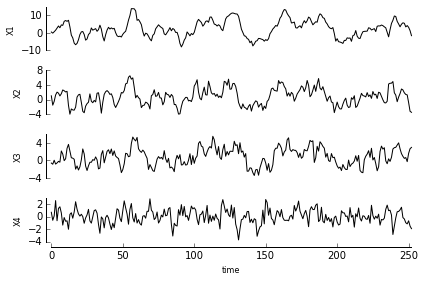

In [3]:
plotting.plot_timeseries(data, datatime, var_names)

In [4]:
verbosity = 1
# Specify conditional independence test object
cond_ind_test = ParCorr(
        use_mask=False,
        mask_type=None,

        significance='analytic',
        sig_samples=100,
        sig_blocklength=None,

        confidence='analytic',
        conf_lev=0.9,
        conf_samples=100,
        conf_blocklength=None,

        verbosity=verbosity)

# cond_ind_test = GPACE(
#         use_mask=False,
#         mask_type=None,

#         significance='analytic',
#         sig_samples=100,
#         sig_blocklength=None,

#         confidence='bootstrap',
#         conf_lev=0.9,
#         conf_samples=100,
#         conf_blocklength=None,
    
#         null_dist_filename='gpace_nulldists_acepack.npz',
#         gp_version='new',
#         gp_kernel=None,
#         gp_alpha=None,
#         gp_restarts=None,
#         ace_version='acepack',
#         verbosity=verbosity)

# cond_ind_test = CMIsymb(
#         use_mask=False,
#         mask_type=None,

#         significance='shuffle_test',
#         sig_samples=100,
#         sig_blocklength=None,

#         confidence=False,
#         conf_lev=0.9,
#         conf_samples=100,
#         conf_blocklength=None,

#         verbosity=verbosity)

if cond_ind_test.measure == 'cmi_symb':
    dataframe.values = pp.quantile_bin_array(dataframe.values, bins=6)

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cond_ind_test,
    var_names=var_names,
    verbosity=verbosity)


## Estimating lagged dependencies


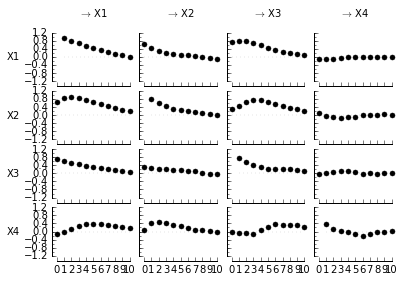

In [5]:
# Get a first view of dependencies by plotting the lagged unconditional dependencies,
# e.g. the lagged correlations.
tau_max_here = 10
correlations = pcmci.get_lagged_dependencies(
                tau_max=tau_max_here,
                )
# Plot lag functions
lag_func_matrix = plotting.setup_matrix(
    N=N,
    tau_max=tau_max_here,
    var_names=var_names)
lag_func_matrix.add_lagfuncs(
    val_matrix=correlations,
    markersize=10,
)

In [7]:
# Run PCMCI for all variables
pc_alpha = 0.2  # [0.1, 0.2, 0.3, 0.4, 0.5]
tau_max = 6

alpha_level = 0.01

results = pcmci.run_pcmci(
    tau_max=tau_max,
    pc_alpha=pc_alpha,
)
pcmci._print_significant_parents(
        p_matrix=results['p_matrix'], 
        q_matrix=results['q_matrix'],
        val_matrix=results['val_matrix'],
        alpha_level=alpha_level,
        conf_matrix=results['conf_matrix'])


##
## Running Tigramite PC algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = 0.2
max_conds_dim = None
max_combinations = 1



## Variable X1

## Variable X2

## Variable X3

## Variable X4

## Resulting condition sets:

    Variable X1 has 3 parent(s):
        (X2 -1): max_pval = 0.00000, min_val = 0.782
        (X1 -1): max_pval = 0.00000, min_val = 0.744
        (X4 -3): max_pval = 0.17821, min_val = 0.086

    Variable X2 has 2 parent(s):
        (X2 -1): max_pval = 0.00000, min_val = 0.693
        (X4 -1): max_pval = 0.00000, min_val = 0.431

    Variable X3 has 6 parent(s):
        (X3 -1): max_pval = 0.00000, min_val = 0.381
        (X1 -1): max_pval = 0.00001, min_val = 0.282
        (X4 -3): max_pval = 0.02196, min_val = 0.146
        (X3 -5): max_pval = 0.08734, min_val = 0.110
        (X3 -2): max_pval = 0.17109, min_val = 0.088
        (X4 -6): max_pval = 0.17515, min_val = 0.087

    Variable X4 has 3 parent(s):
        (X4 -1): max

In [13]:
# Print out matrices of p-values and test statistic values

link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
                                  val_matrix=results['val_matrix'],
                                  alpha_level=0.05,
                                  )['link_matrix']


## Visualization

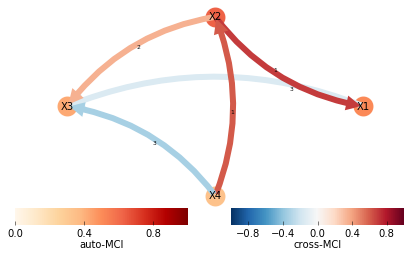

In [14]:
# Plot graph
plotting.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
)

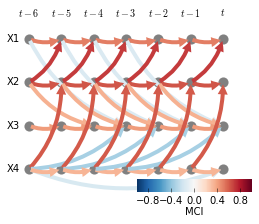

In [15]:
# Plot time series graph
plotting.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
        )

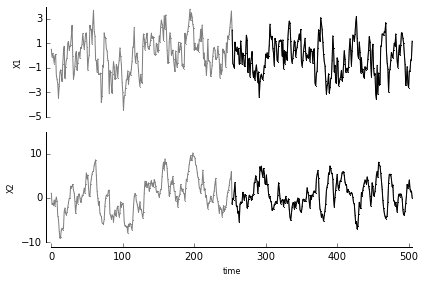

In [16]:
# Masking
numpy.random.seed(42)
c = .9
T = 253
# One part of data
links_coeffs1 = {0: [((0, -1), .8)],
                1: [((1, -1), .7), ((0, -1), c)],
                }
data1, _ = pp.var_process(links_coeffs1, T=T)
# Other part of data
links_coeffs2 = {0: [((0, -1), .8)],
                1: [((1, -1), .7), ((0, -1), -c)],
                }
data2, _ = pp.var_process(links_coeffs2, T=T)

data = numpy.concatenate((data1, data2), axis=0)
T, N = data.shape

# Data mask
data_mask = numpy.zeros(data.shape)
data_mask[:T/2] = True

dataframe = pp.DataFrame(data, mask=data_mask)
plotting.plot_timeseries(data,  var_names=var_names, use_mask=True, mask=data_mask, 
                             grey_masked_samples='data')


In [17]:
# Setup whole analysis
def run_and_plot(cond_ind_test):
    pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=cond_ind_test,
        var_names=var_names,
        verbosity=0)

    # Run PCMCI for all variables
    pc_alpha = 0.2  # [0.1, 0.2, 0.3, 0.4, 0.5]
    tau_max = 6

    alpha_level = 0.01

    results = pcmci.run_pcmci(
        tau_max=tau_max,
        pc_alpha=pc_alpha,
    )

    link_matrix = pcmci._return_significant_parents(
                                  pq_matrix=results['p_matrix'],
                                  val_matrix=results['val_matrix'],
                                  alpha_level=alpha_level,
                                  )['link_matrix']
    plotting.plot_graph(
        val_matrix=results['val_matrix'],
        link_matrix=link_matrix,
        var_names=var_names,
    )

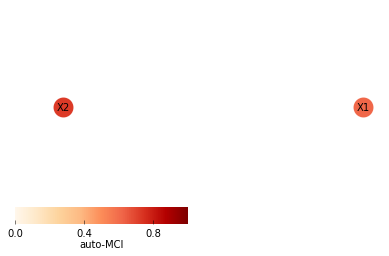

In [18]:
# Causal graph of whole time series
cond_ind_test = ParCorr(
        use_mask=False)
run_and_plot(cond_ind_test)

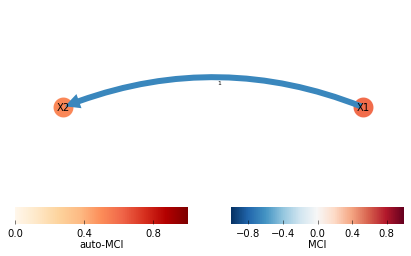

In [19]:
# Causal graph of masked time series
cond_ind_test = ParCorr(
        use_mask=True, mask_type=['y'])
run_and_plot(cond_ind_test)

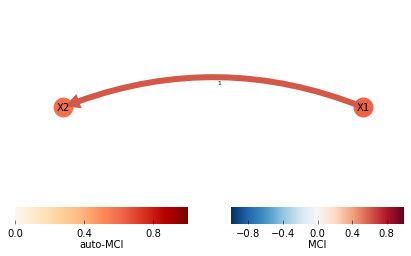

In [20]:
# Other half
dataframe.mask = dataframe.mask == False
cond_ind_test = ParCorr(
        use_mask=True, mask_type=['y'])
run_and_plot(cond_ind_test)